#DR Grading 
#Author : Nasrin Alipour
#Date : 14 NOV 2021

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16 as PTModel
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from tensorflow.keras.applications.inception_v3 import InceptionV3 as PTModel
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
# io related
from skimage.io import imread
import os
import glob
#import cv2
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

Init Plugin
Init Graph Optimizer
Init Kernel


## Download Dataset

In [ ]:
!gdown 1_gmRXJ3Wc9lNScbAlC3Jt1zOwpFHfDgE
!gdown 14a5HcSTtGwEchKMpUGieuv0rNfm0Mbs9
!gdown 10i8OzBuHqPICgrkxoGLpHPy_3nDg0buX
!gdown 1-26gAtV2TsoLioT3BsL8S5sieHLW3z-c
!gdown 1joj-KN556wtnzipQ54OpPBMXM-pW-oJ9
!gdown 1rNV-yqdcG5j9ZA05G0lmiZUc3xK7YRFv
!gdown 12U7sn-8UwBgeL5pY7EOYUJAyqjFxTHS6
!gdown 1fJwdYVO8_lDeJI8ic1yr7sl5RtqYfxOW
!gdown 1rrWddjsrmrwKQVCWU9x7onVkgMdtv0Wf
!gdown 1RxRx_ImIDAmUp1h8BNaqVJ9LJ0jCmyua

!cat DDR-dataset.zip* > ./DDR-dataset.zip

!rm DDR-dataset.zip.*

!unzip /content/DDR-dataset.zip

!rm DDR-dataset.zip

DDR_PATH='DDR-dataset/DR_grading/'

## load Data

In [ ]:
path_traindf= DDR_PATH +'train.txt'
path_validdf= DDR_PATH + 'valid.txt'
path_testdf= DDR_PATH + 'test.txt'
traindf = pd.read_csv(path_traindf, sep=" ", header=None)
traindf.columns = ["filename", "grade"]
validdf = pd.read_csv(path_validdf, sep=" ", header=None)
validdf.columns = ["filename", "grade"]
testdf = pd.read_csv(path_testdf, sep=" ", header=None)
testdf.columns = ["filename", "grade"]

traindf['grade'] = traindf['grade'].astype(str)
validdf['grade'] = validdf['grade'].astype(str)
testdf['grade'] = testdf['grade'].astype(str)

In [ ]:
traindf = traindf.replace({'5':np.nan})
traindf = traindf.dropna()

validdf = validdf.replace({'5':np.nan})
validdf = validdf.dropna()

testdf = testdf.replace({'5':np.nan})
testdf = testdf.dropna()

In [ ]:
display(validdf)

,filename,grade
0,20170323093705822.jpg,0
1,20170323093707381.jpg,0
2,20170323093821503.jpg,0
3,20170323093944125.jpg,0
4,20170323093945725.jpg,0
...,...,...
2498,007-6953-400.jpg,4
2499,007-6956-400.jpg,4
2500,007-6957-400.jpg,4
2501,007-6958-400.jpg,4


In [ ]:
len(traindf.filename.unique())

6260

## Data augmentation & create datasets

In [ ]:
# config
tar_width, tar_height = int(240), int(300)#512, 512
input_depth = 1 #1: gray image
#PATH_train="/content/drive/MyDrive/messidor_images_train/"
PATH_train = DDR_PATH + 'train'
PATH_valid = DDR_PATH + 'valid'
PATH_test = DDR_PATH + 'test'
bs = 64
l2_decay = 0.000001

In [ ]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    #validation_split=0.25,
    featurewise_center=False,
    featurewise_std_normalization=False,
    #rotation_range=90,
    #brightness_range=[]
    #width_shift_range=0.2,
    #shear_range=0.0,
    #height_shift_range=0.2,
    horizontal_flip=True,
    #vertical_flip=True
    #preprocessing_function = preprocess_input
    )

test_datagen = ImageDataGenerator(
    rescale=1./255.,
    featurewise_center=False,
    featurewise_std_normalization=False,
    )

In [ ]:
# Define a function to crop the images (removing black background)
def crop_generator(batches, new_size):
    while True:
        batch_x, batch_y = next(batches)
        x= batch_x.shape[1] // 2
        y= batch_x.shape[2] // 2
        size = new_size // 2
        yield ((((batch_x[:, x-size:x+size, y-size:y+size])*255)*1.05)/255, batch_y)

In [ ]:
# Train Dataset
train_generator=crop_generator(train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=PATH_train,
x_col="filename",
y_col="grade",
#subset="training",
batch_size=bs, 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(tar_width, tar_height)), new_size= 224)

# Validation Dataset
valid_generator=crop_generator(train_datagen.flow_from_dataframe(
dataframe=validdf,
directory=PATH_valid,
x_col="filename",
y_col="grade",
#subset="validation",
batch_size=bs,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(tar_width, tar_height)), new_size= 224)

# Test Dataset
test_generator=crop_generator(test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=PATH_test,
x_col="filename",
y_col="grade",
batch_size=bs,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(tar_width, tar_height)), new_size=224)


Found 6260 validated image filenames belonging to 5 classes.
Found 2503 validated image filenames belonging to 5 classes.
Found 3759 validated image filenames belonging to 5 classes.


## plot augmented data

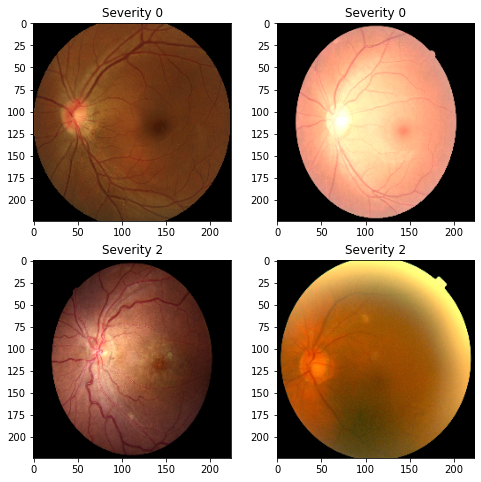

In [ ]:
t_x, t_y = next(valid_generator)
fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*255, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))

## show effect of intensity transfomation

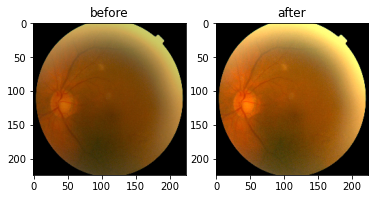

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.clip((c_x*255)**(1/1.05), 0, 255).astype(np.uint8))
plt.title('before')

plt.subplot(1,2,2)
plt.imshow(np.clip(c_x*255, 0, 255).astype(np.uint8))
plt.title('after')
plt.show()

In [ ]:
c_x[:,:,1].shape

(224, 224)

## Create Model

### InceptionV3 + attention mechanism **CABNet**
https://ieeexplore.ieee.org/document/9195035

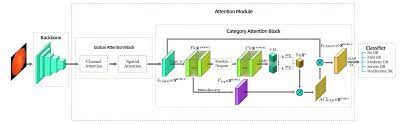

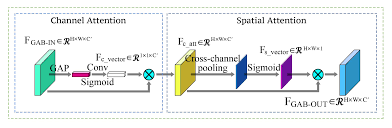

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
def Global_attention_block(inputs):
    shape=K.int_shape(inputs)
    x=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('relu') (x)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('sigmoid') (x)
    C_A=Multiply()([x,inputs])
    
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (C_A)
    x=Activation('sigmoid') (x)
    S_A=Multiply()([x,C_A])
    return S_A

def Category_attention_block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F=Conv2D(k*classes,1, padding='same') (inputs)
    F=BatchNormalization() (F)
    F1=Activation('relu') (F)
    
    F2=F1
    x=GlobalMaxPool2D()(F2)
    
    x=Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    
    x=Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    x=Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (x)
    
    semantic=Multiply()([inputs,M])
    return semantic

In [ ]:
k = 5
classes = 5
in_lay = Input(shape=(224, 224, 3))
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3)) 
base_out = base_model(in_lay)
x=Global_attention_block(base_out)
base_out=Category_attention_block(x,classes,k)
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)
model = Model(inputs = [in_lay], outputs = [out])
model.summary()

Metal device set to: Apple M1


2022-11-11 10:18:27.500490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-11 10:18:27.500783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_9 (AveragePoo (None, 1, 1, 2048)   0           inception_v3[0][0]               
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 1, 1, 2048)   4196352     average_pooling2d_9[0][0]        
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
loss_fun= 'categorical_crossentropy'  
gpu_num=1
lr1=0.005
lr2=0.0001
batch_size= 128
image_size=224
train_num , valid_num = 6260,2503
save_name = 'Inception_messidor_bin'
Epochs1, Epochs2 = 1, 40
lr_decay=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',save_freq=10)

for layer in base_model.layers:
    layer.trainable = False   

model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
model.fit(train_generator,
                    steps_per_epoch=train_num//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_num//batch_size,
                    epochs=Epochs1, 
                    workers=0)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
history=model.fit(train_generator,
                    steps_per_epoch=train_num//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_num//batch_size,
                    epochs=Epochs2,
                    workers=0,
                    callbacks=callbacks_list)

/Users/nasrinalipour/miniforge3/envs/tensor/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-11-11 10:20:31.561683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-11 10:20:31.563154: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-11 10:20:32.744119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 1.0285 - acc: 0.5895

2022-11-11 10:22:58.881650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 197s 4s/step - loss: 1.0285 - acc: 0.5895 - val_loss: 1.0151 - val_acc: 0.6201
Epoch 1/40


2022-11-11 10:23:52.947265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 1.0199 - acc: 0.6058

2022-11-11 10:27:26.304868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 269s 6s/step - loss: 1.0199 - acc: 0.6058 - val_loss: 2.5405 - val_acc: 0.5757

Epoch 00001: val_loss improved from inf to 2.54048, saving model to retina_weights.best.hdf5
Epoch 2/40
48/48 [==============================] - 414s 9s/step - loss: 0.7877 - acc: 0.6974 - val_loss: 1.0960 - val_acc: 0.6868

Epoch 00002: val_loss improved from 2.54048 to 1.09604, saving model to retina_weights.best.hdf5
Epoch 3/40
48/48 [==============================] - 271s 6s/step - loss: 0.7534 - acc: 0.7067 - val_loss: 0.7769 - val_acc: 0.7664

Epoch 00003: val_loss improved from 1.09604 to 0.77694, saving model to retina_weights.best.hdf5
Epoch 4/40
48/48 [==============================] - 256s 5s/step - loss: 0.6199 - acc: 0.7542 - val_loss: 0.9128 - val_acc: 0.7248

Epoch 00004: val_loss did not improve from 0.77694
Epoch 5/40
48/48 [==============================] - 517s 11s/step - loss: 0.6041 - acc: 0.7627 - val_loss: 0.7836 - val_acc: 0.7763

Epoch 00005:

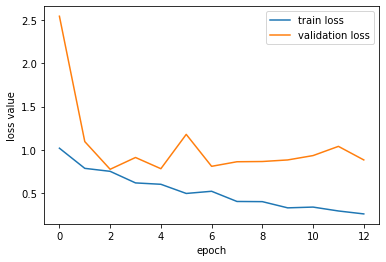

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend(['train loss', 'validation loss'])

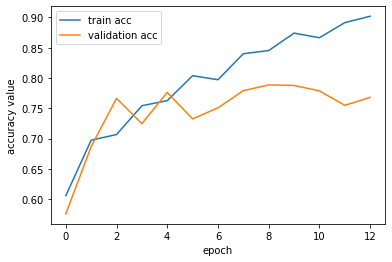

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.legend(['train acc', 'validation acc'])

## evaluating

In [ ]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
vbatch_count = (100//32-1)
out_size = vbatch_count*bs
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), valid_generator):
    j = i*bs
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

/var/folders/h_/b72jc49d1hg9h06vl56001xr0000gn/T/ipykernel_86397/3455558906.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), valid_generator):


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model.load_weights(weight_path)
model.save('full_retina_model.h5')

/Users/nasrinalipour/miniforge3/envs/tensor/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## show attention

In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [ ]:
model.layers[-4].output

<KerasTensor: shape=(None, 5, 5, 1) dtype=float32 (created by layer 'lambda_3')>

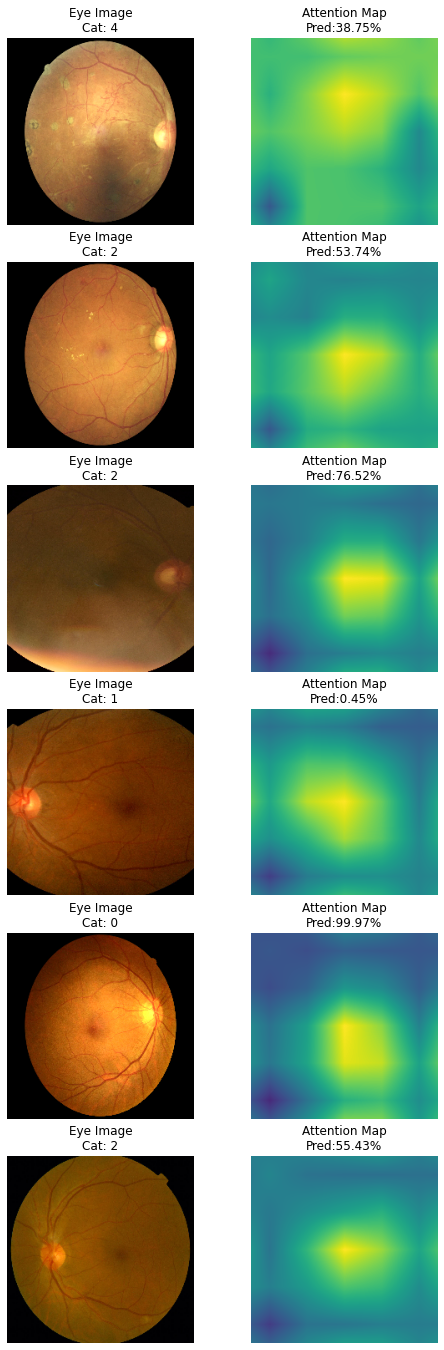

In [ ]:
import tensorflow.keras.backend as K
import skimage
rand_idx = np.random.choice(range(len(test_X)), size = 6)
#attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()], outputs = [attn_layer.get_output_at(0)])
attn_func = K.function(inputs = [model.layers[0].output], outputs = [model.layers[8].output])

fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*255, 0, 255).astype(np.uint8))
    #skimage.transform.rescale
    attn_ax.imshow(skimage.transform.resize((attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max())*255, (224,224)), cmap = 'viridis', 
    #attn_ax.imshow((skimage.transform.resize((attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max())*255, (224,224)) + np.clip(cur_img[0,:,:,0]*255, 0, 250).astype(np.uint8))/2, cmap = 'viridis', 

    #attn_ax.imshow((cv2.resize((attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max())*255, (512,512), interpolation=cv2.INTER_CUBIC) + np.clip(cur_img[0,:,:,0]*255, 0, 255).astype(np.uint8))/2, cmap = 'viridis', 
                   vmin = 0, vmax = 255, 
                   interpolation = 'lanczos')
    #attn_ax.imshow(np.clip(cur_img[0,:,:,:]*255, 0, 255).astype(np.uint8))
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = model.predict(test_X, batch_size = bs, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

2022-11-11 11:32:52.227297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 442ms/step
Accuracy on Test Data: 0.84%
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        74
           1       0.00      0.00      0.00         6
           2       0.82      0.80      0.81        40
           3       0.00      0.00      0.00         1
           4       0.70      1.00      0.82         7

    accuracy                           0.84       128
   macro avg       0.48      0.55      0.51       128
weighted avg       0.81      0.84      0.82       128



/Users/nasrinalipour/miniforge3/envs/tensor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nasrinalipour/miniforge3/envs/tensor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nasrinalipour/miniforge3/envs/tensor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
pr=pred_Y_cat
ts=test_Y_cat

In [ ]:
for i in range(len(pr)):
  if pr[i]>0:
    pr[i]=1

for i in range(len(ts)):
  if ts[i]>0:
    ts[i]=1    

In [ ]:
accuracy_score(test_Y_cat, pred_Y_cat)

0.8203125

In [ ]:
print(classification_report(test_Y_cat, pred_Y_cat))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86        74
           1       0.90      0.65      0.75        54

    accuracy                           0.82       128
   macro avg       0.84      0.80      0.81       128
weighted avg       0.83      0.82      0.81       128



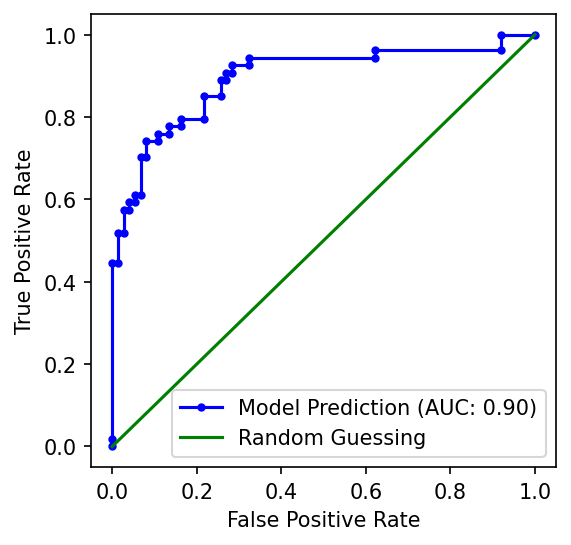

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

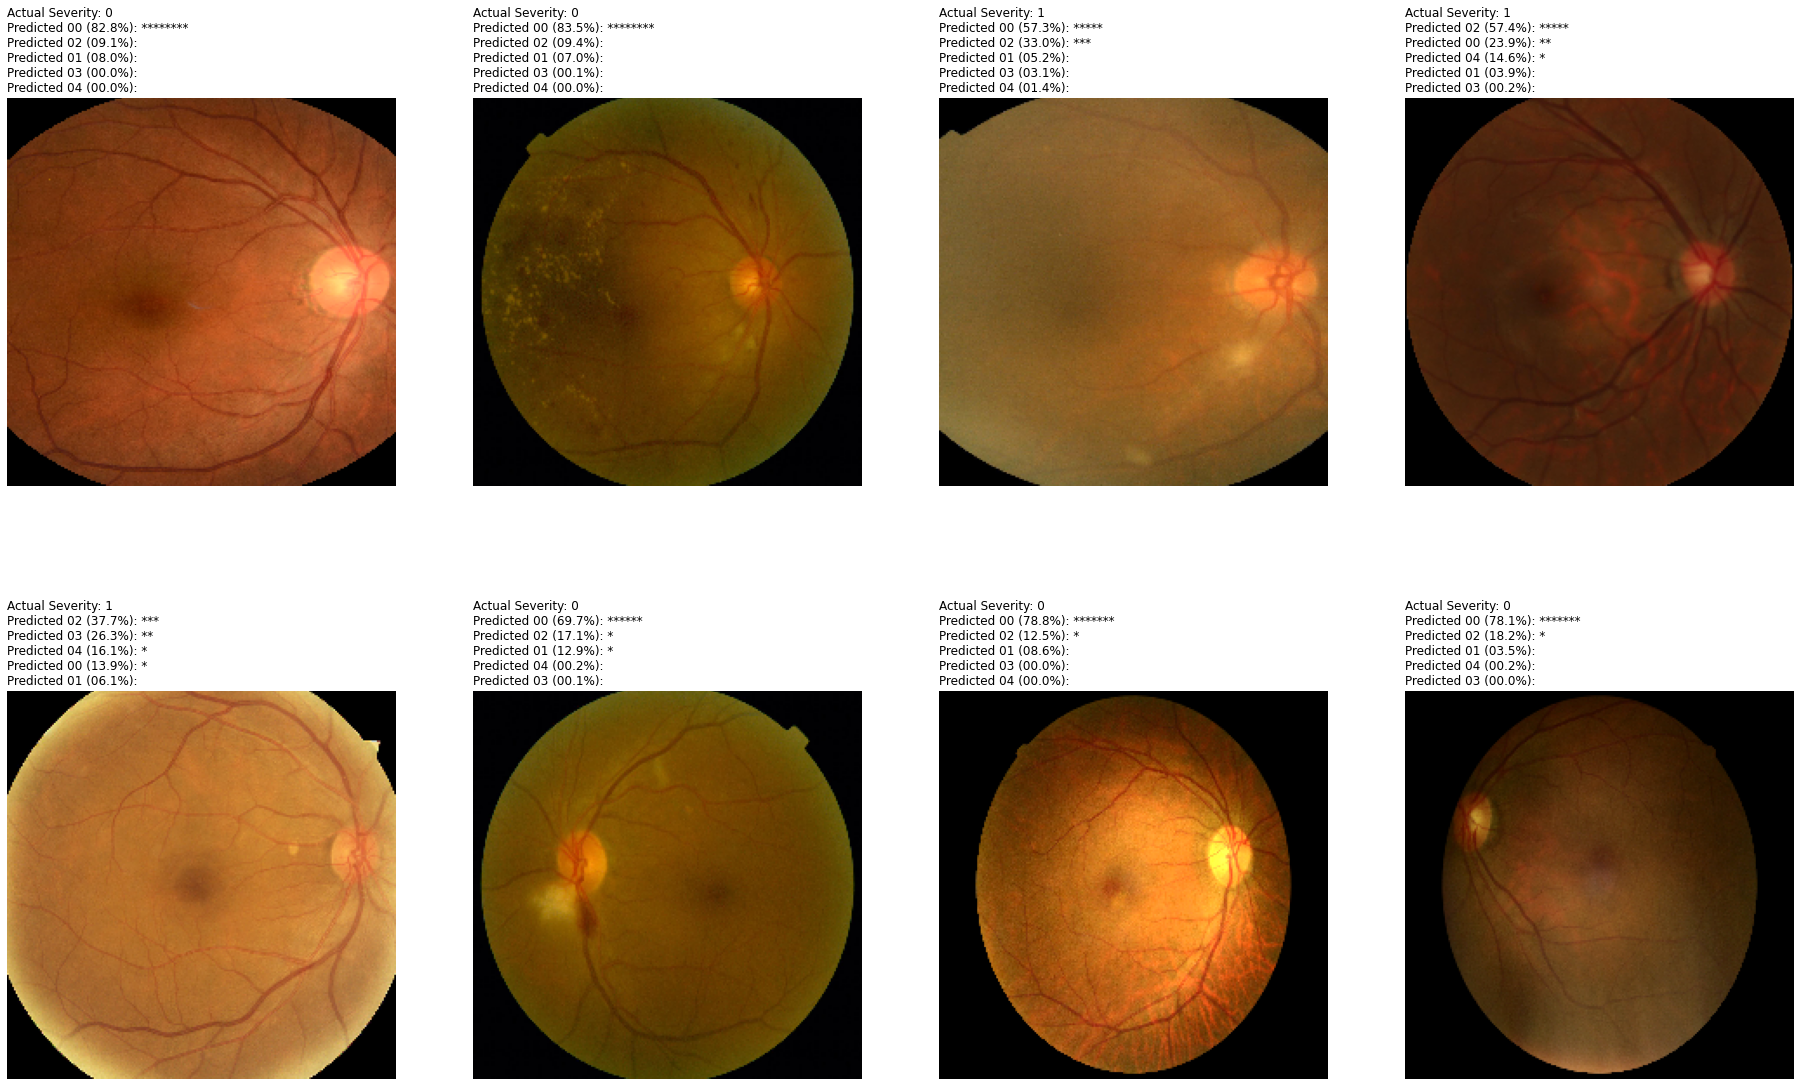

In [ ]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*255,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)